Goal: Calculate necessary data for plotting

Last time everything was combined in the Rdf_to_Figures file making it unnecessarily tedious. This time, we only calculate and save necessary values and will plot it in another notebook.

In addition, the 40Hz FFR which was recorded in both sessions will be merged in section 1 and resampled in section 2. As there was no significant difference between sessions (see Merging_Sessions_Test.notebook and Checking_Merging_Sessions.rmd)



### Note on 04/18/22

THe older version has been modified to address reviewers' comment:

1. The pre-stimulus detrend baseline was changed to -100ms~0ms

2. The noise frequency band has been shortened

3. Drop session 2 and only use session 1 for analyzing the results

In [2]:
cd

/home/luxx0489


In [3]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
import pickle
import mne
from scipy.stats import circmean,circvar
from sklearn import decomposition

import time

# Section 1: Interpreting vetical montage FFR

## Fig. 0 the phase topomap

In [3]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000]
End_trial_list = [1000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),67))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data, axis=2)
            
        for iFreq in range(len(Freq_list)):
            
            xw = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]

            plv = np.angle((xw/abs(xw)).mean(0))

            freq = np.fft.rfftfreq(data.shape[2],1/4096)

            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = iRef
            output[row_num,2] = Freq_list[iFreq]
            output[row_num,3:67] = plv[:,index]  #Phase of all
            
            row_num +=1

folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF"
file_handle = open(folder_path + '/phase_topomap_all_HL041822.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-758ce52466a6>", line 28, in <module>
    epochs_L.load_data()
  File "/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/mne/epochs.py", line 556, in load_data
    self._data = self._get_data()
  File "</home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/mne/externals/decorator.py:decorator-gen-178>", line 2, in _get_data
  File "/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/mne/utils/_logging.py", line 90, in wrapper
    return function(*args, **kwargs)
  File "/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/mne/epochs.py", line 1322, in _get_data
    epoch_noproj = self._detrend_offset_decim(epoch_noproj)
  File "</home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/mne/externals/decorator.py:decorator-ge

KeyboardInterrupt: 

## Fig. 1

In [4]:
folder_path = "./jupyter_projects/MultiChannelSSSR"
file_handle = open(folder_path +'/freq_label.obj','rb')
freq = pickle.load(file_handle)
file_handle.close()

In [5]:
# define functions (requires freq variable)

def ztransform(val, noise):
    return (val-noise.mean())/noise.std()

Target_list = [[34.28,43.43],[91.42,98.28],[233.13,217.13]]
#Noise_range_list = [[20,55],[75,110],[205,240]]

Noise_range_list = [[30,50],[85,105],[215,235]]

Noise_index = []
for iFreq in range(3):
    index1 = np.argmin(abs(freq-Target_list[iFreq][0]))
    index2 = np.argmin(abs(freq-Target_list[iFreq][1]))
    Noise_range = np.arange(np.argmin(abs(freq-Noise_range_list[iFreq][0])),np.argmin(abs(freq-Noise_range_list[iFreq][1])))
    key1 = np.argwhere(Noise_range==index1)
    key2 = np.argwhere(Noise_range==index2)
    
    Noise_index.append(np.delete(Noise_range,[key1,key2]))

In [6]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000]
End_trial_list = [1000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),7))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data, axis=2)
            
        for iFreq in range(len(Freq_list)):
            
            xw = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            
            data_ave = data[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:].mean(0)
            xw_ave = np.fft.rfft(np.hamming(data_ave.shape[1])*data_ave, axis=1)

            plv = abs((xw/abs(xw)).mean(0))
            mag = abs(xw_ave)
            
            freq = np.fft.rfftfreq(data.shape[2],1/4096)

            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = iRef
            output[row_num,2] = Freq_list[iFreq]
            output[row_num,3] = mag[47,index]  #Cz spectral magnitude
            output[row_num,4] = plv[47,index]  #Cz plv
            output[row_num,5] = mag[47,Noise_index[iFreq]].mean() #Fz noise floor
            output[row_num,6] = plv[47,Noise_index[iFreq]].mean() #Cz noise floor
            

            
            row_num +=1
            
file_handle = open(folder_path + '/absolute_PLV_and_ave_Mag_all_HL041822.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub12_LF/Sub12_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3321855  =      0.000 ...   811.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub12_HF/Sub12_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3411967  =      0.000 ...   833.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_eve

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub19_LF/Sub19_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3514367  =      0.000 ...   858.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub19_HF/Sub19_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3358719  =      0.000 ...   820.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_eve

## Fig.2 and 3: amplitude and phase of PLV at vertex and mastoids

In [7]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000, 0, 0, 1000]
End_trial_list = [1000, 1000, 2000, 1000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),11))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    
    # combine and fft
    for iRef in range(1):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        linked_mastoid = data[:,64:66,:].mean(1)
        diff_horizontal = data[:,64,:] - data[:,65,:]
        vertex_channel = data[:,47,:] + data[:,46,:]
        refs = np.dstack((linked_mastoid,diff_horizontal,vertex_channel)).transpose(0,2,1)

        xw_all = np.fft.rfft(np.hamming(data.shape[2])*refs, axis=2)
        freq = np.fft.rfftfreq(data.shape[2],1/4096)  
        
        for iFreq in range(len(Freq_list)):
            
            xw = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]

            plv = abs((xw/abs(xw)).mean(0))
            phase = np.angle((xw/abs(xw)).mean(0))


            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = Freq_list[iFreq]
            output[row_num,2:5] = plv[:,index]
            output[row_num,5:8] = phase[:,index]
            output[row_num,8:11] = plv[:,Noise_index[iFreq]].mean(1) #Fz noise floor
            
            row_num +=1

file_handle = open(folder_path + '/Fig23_location_PLV_all_HL041822.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3411967  =      0.000 ...   833.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub14_LF/Sub14_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3268607  =      0.000 ...   798.000 secs...
Trigger c

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3547135  =      0.000 ...   866.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub20_HF/Sub20_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3338239  =      0.000 ...   815.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mea

In [8]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000, 0, 0, 1000]
End_trial_list = [1000, 1000, 2000, 1000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),11))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    
    # combine and fft
    for iRef in range(1):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        linked_mastoid = data[:,64:66,:].mean(1)
        diff_horizontal = data[:,64,:] - data[:,65,:]
        vertex_channel = data[:,47,:] + data[:,46,:]
        refs = np.dstack((linked_mastoid,diff_horizontal,vertex_channel)).transpose(0,2,1)

        freq = np.fft.rfftfreq(data.shape[2],1/4096)  
        
        for iFreq in range(len(Freq_list)):
            
            refs_ave = refs[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:].mean(0)
            xw_ave = np.fft.rfft(np.hamming(refs_ave.shape[1])*refs_ave, axis=1)
            
            mag = abs(xw_ave)

            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = Freq_list[iFreq]
            output[row_num,2:5] = mag[:,index]
            output[row_num,5:8] = 0
            output[row_num,8:11] = mag[:,Noise_index[iFreq]].mean(1) #Fz noise floor
            
            row_num +=1

file_handle = open(folder_path + '/Fig23_location_mag_all_HL041822.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3411967  =      0.000 ...   833.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub14_LF/Sub14_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3268607  =      0.000 ...   798.000 secs...
Trigger c

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3547135  =      0.000 ...   866.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub20_HF/Sub20_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3338239  =      0.000 ...   815.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mea

# Section 2. Compare multichannel recording methods

In [9]:
# define functions (requires freq variable)

def ztransform(val, noise):
    return (val-noise.mean())/noise.std()

Target_list = [[34.28,43.43],[91.42,98.28],[233.13,217.13]]
#Noise_range_list = [[20,55],[75,110],[205,240]]
Noise_range_list = [[30,50],[85,105],[215,235]]

Noise_index = []
for iFreq in range(3):
    index1 = np.argmin(abs(freq-Target_list[iFreq][0]))
    index2 = np.argmin(abs(freq-Target_list[iFreq][1]))
    Noise_range = np.arange(np.argmin(abs(freq-Noise_range_list[iFreq][0])),np.argmin(abs(freq-Noise_range_list[iFreq][1])))
    key1 = np.argwhere(Noise_range==index1)
    key2 = np.argwhere(Noise_range==index2)
    
    Noise_index.append(np.delete(Noise_range,[key1,key2]))

In [10]:
ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
sample_size = [200,400,600,800,1000]
output = np.empty((len(ID_list)*2*len(Freq_list)*len(sample_size),16))
Start_trial_list = [0, 0, 1000]
End_trial_list = [1000, 1000, 2000]

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# all chan plv, 
# all chan ITC,
# all chan T2,
# tPCA, cPCA

row_num = 0

for iSubject in ID_list:
    
    t = time.time()
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    
    print('loading took %s' % (time.time()-t))
    t = time.time()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data_all = np.concatenate((data_L,data_H),0)
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data_all, axis=2)
        
        
        for iFreq in range(len(Freq_list)):
            
            xw_session = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            data = data_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            
            for iSize in range(len(sample_size)):
                ind_sample = sample(range(End_trial_list[iFreq]- Start_trial_list[iFreq]),sample_size[iSize])
                xw=xw_session[ind_sample,:,:]
                
                # plv and itc
                plv = abs((xw/abs(xw)).mean(0))
                itc = abs(xw.mean(0))/(abs(xw).mean(0))
                
                # plv and itc, mean and rms
                plv_mean = plv[0:64,:].mean(0)
                itc_mean = itc[0:64,:].mean(0)
                plv_rms = np.sqrt((plv[0:64,:]**2).mean(0))
                itc_rms = np.sqrt((itc[0:64,:]**2).mean(0))
                
                print('PLV took %s' % (time.time()-t))
                t = time.time()
                
                # hotelling's t2
                out = xw[:,0:64,:]
                sample_dat = np.concatenate((np.real(out),np.imag(out)),axis=1)
                T2 = np.zeros(sample_dat.shape[2])
                
                for iBar in range(5,sample_dat.shape[2]-3):
                    batch = sample_dat[:,:,iBar].transpose(1,0)
                    S_inv = np.linalg.inv(np.cov(batch))
                    T2[iBar]=batch.mean(1) @S_inv @batch.mean(1)
                
                print('T2 took %s' % (time.time()-t))
                t = time.time()
                
                
                #cPCA and MMSC, share a loop because they both use csd
                plv_mat=np.empty((64,xw.shape[2]))
                msmc = np.empty(xw.shape[2])
                for iBar in range(max(Noise_index[2])+1):   
                    #as this section is most computationally expensive, not all bars will be calculated
                    # only those frequency bars that will be used in calculating normalized scores are used
                    # i.e. max(Noize_index)
                    
                    # cPCA
                    csd = np.matmul(xw[:,0:64,iBar].T,xw[:,0:64,iBar].conj())
                    w,v = np.linalg.eig(csd)
                    pc = np.matmul(v.conj().T,xw[:,0:64,iBar].T)
                    cplv = (pc/abs(pc)).mean(1)
                    plv_mat[:,iBar] = abs(cplv)
                
                    # MSMC
                    v_m = np.matrix(xw[:,0:64,iBar].mean(0))
                    msmc[iBar] = np.real((v_m.conj() @ np.linalg.inv(csd) @ v_m.T)[0,0])
                
                
                print('cPCA and MMSC took %s' % (time.time()-t))
                t = time.time()
                    
                    
                # concatenate and tPCA
                mix_long = np.concatenate([data[iTrial,0:64,:] for iTrial in ind_sample], axis=1)

                pca = decomposition.PCA(n_components=1)
                pca.fit(mix_long.T)
                pc_t = np.empty((sample_size[iSize],data.shape[2]))
                for iTrial in range(len(ind_sample)):
                    pc_t[iTrial,:] = pca.transform(data[ind_sample[iTrial],0:64,:].T).squeeze()
                xw_pc_t = np.fft.rfft(pc_t, axis=1)
                xw_pc_t = xw_pc_t/abs(xw_pc_t)
                plv_pc_t = abs(xw_pc_t.mean(0))
                
                print('tPCA took %s' % (time.time()-t))
                t = time.time()
                
                index = np.argmin(abs(freq-Freq_list[iFreq]))

                output[row_num,0] = iSubject
                output[row_num,1] = iRef
                output[row_num,2] = Freq_list[iFreq]
                output[row_num,3] = sample_size[iSize]
                output[row_num,4] = ztransform(plv[37,index],plv[37,Noise_index[iFreq]])
                output[row_num,5] = ztransform(itc[37,index],itc[37,Noise_index[iFreq]])
                output[row_num,6] = ztransform(plv[47,index],plv[47,Noise_index[iFreq]])
                output[row_num,7] = ztransform(itc[47,index],itc[47,Noise_index[iFreq]])
                output[row_num,8] = ztransform(plv_mean[index],plv_mean[Noise_index[iFreq]])
                output[row_num,9] = ztransform(itc_mean[index],itc_mean[Noise_index[iFreq]])
                output[row_num,10] = ztransform(plv_rms[index],plv_mean[Noise_index[iFreq]])
                output[row_num,11] = ztransform(itc_rms[index],itc_mean[Noise_index[iFreq]])
                output[row_num,12] = ztransform(T2[index],T2[Noise_index[iFreq]])
                output[row_num,13] = ztransform(plv_mat[0,index],plv_mat[0,Noise_index[iFreq]])
                output[row_num,14] = ztransform(plv_pc_t[index],plv_pc_t[Noise_index[iFreq]])
                output[row_num,15] = ztransform(msmc[index], msmc[Noise_index[iFreq]])

                row_num +=1

file_handle = open(folder_path + '/method_comparison_all_HL041822.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

PLV took 2.442173719406128
T2 took 1.9959731101989746
cPCA and MMSC took 4.266503095626831
tPCA took 3.8718955516815186
PLV took 3.2465360164642334
T2 took 2.4821252822875977
cPCA and MMSC took 5.521713733673096
tPCA took 5.393612384796143
PLV took 4.03568434715271
T2 took 2.9383933544158936
cPCA and MMSC took 6.749703884124756
tPCA took 6.76263952255249
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
PLV took 4.421041965484619
T2 took 1.1208124160766602
cPCA and MMSC took 1.563838005065918
tPCA took 1.1832797527313232
PLV took 1.645859956741333
T2 took 1.5655460357666016
cPCA and MMSC took 3.030683994293213
tPCA took 2.6210854053497314
PLV took 2.4408721923828125
T2 took 2.0182383060455322
cPCA and MMSC took 4.247928857803345
tPCA took 3.8817765712738037
PLV took 3.2475383281707764
T2 took 2.4545233249664307
cPCA and MMSC took 5.612904071807861
tPCA took 5.39867901802063
PLV too

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub9_HF/Sub9_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3305471  =      0.000 ...   807.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
loading took 10.908185482025146
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
PLV took 5.724261522293091
T2 took 1.1196832656860352
cPCA and MMSC took 1.5656678676605225
tPCA took 1.1756417751312256

PLV took 1.6017940044403076
T2 took 1.5363271236419678
cPCA and MMSC took 3.0001561641693115
tPCA took 2.6422603130340576
PLV took 2.371762275695801
T2 took 1.9951393604278564
cPCA and MMSC took 4.3546507358551025
tPCA took 3.9656283855438232
PLV took 3.149935007095337
T2 took 2.454472064971924
cPCA and MMSC took 5.661370038986206
tPCA took 5.376981019973755
PLV took 3.9301507472991943
T2 took 2.9345767498016357
cPCA and MMSC took 6.924171686172485
tPCA took 6.75810432434082
PLV took 0.8291475772857666
T2 took 1.1127262115478516
cPCA and MMSC took 1.5743017196655273
tPCA took 1.2905752658843994
PLV took 1.605621337890625
T2 took 1.5474720001220703
cPCA and MMSC took 3.011632204055786
tPCA took 2.618685245513916
PLV took 2.3736767768859863
T2 took 1.9880030155181885
cPCA and MMSC took 4.358009338378906
tPCA took 3.981309652328491
PLV took 3.1557090282440186
T2 took 2.459319829940796
cPCA and MMSC took 5.606670618057251
tPCA took 5.380673170089722
PLV took 3.9369044303894043
T2 took 2.93

0 bad epochs dropped
loading took 10.108879327774048
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
PLV took 5.727745532989502
T2 took 1.1120028495788574
cPCA and MMSC took 1.552612543106079
tPCA took 1.3265564441680908
PLV took 1.640721321105957
T2 took 1.5403048992156982
cPCA and MMSC took 3.054497241973877
tPCA took 2.7014193534851074
PLV took 2.4301517009735107
T2 took 1.9830148220062256
cPCA and MMSC took 4.252420425415039
tPCA took 3.966566324234009
PLV took 3.2174973487854004
T2 took 2.4203941822052
cPCA and MMSC took 5.41885781288147
tPCA took 5.375157594680786
PLV took 4.027022123336792
T2 took 2.8735005855560303
cPCA and MMSC took 6.634803771972656
tPCA took 6.743917465209961
PLV took 0.8464977741241455
T2 took 1.1101727485656738
cPCA and MMSC took 1.5381224155426025
tPCA took 1.264847755432129
PLV took 1.64073014

PLV took 1.6414270401000977
T2 took 1.5328412055969238
cPCA and MMSC took 2.962559223175049
tPCA took 2.6073760986328125
PLV took 2.44185471534729
T2 took 1.9900903701782227
cPCA and MMSC took 4.224209308624268
tPCA took 3.961243152618408
PLV took 3.240295171737671
T2 took 2.4389216899871826
cPCA and MMSC took 5.5429558753967285
tPCA took 5.403198003768921
PLV took 4.0466625690460205
T2 took 2.9117398262023926
cPCA and MMSC took 6.779153347015381
tPCA took 6.743928670883179
PLV took 0.8467922210693359
T2 took 1.1116511821746826
cPCA and MMSC took 1.54050612449646
tPCA took 1.1854488849639893
PLV took 1.6442670822143555
T2 took 1.53851318359375
cPCA and MMSC took 2.949861764907837
tPCA took 2.6480648517608643
PLV took 2.436661958694458
T2 took 1.9838533401489258
cPCA and MMSC took 4.237767219543457
tPCA took 3.961087465286255
PLV took 3.2374322414398193
T2 took 2.4350361824035645
cPCA and MMSC took 5.507754802703857
tPCA took 5.405178546905518
PLV took 4.042277097702026
T2 took 2.921836

tPCA took 3.982511043548584
PLV took 3.244600296020508
T2 took 2.4329581260681152
cPCA and MMSC took 5.563208103179932
tPCA took 5.4008214473724365
PLV took 4.058241844177246
T2 took 2.9360156059265137
cPCA and MMSC took 6.823334693908691
tPCA took 6.748268127441406
PLV took 0.8505387306213379
T2 took 1.1063652038574219
cPCA and MMSC took 1.5807969570159912
tPCA took 1.2787916660308838
PLV took 1.6381289958953857
T2 took 1.541234016418457
cPCA and MMSC took 2.9911582469940186
tPCA took 2.6844422817230225
PLV took 2.437156915664673
T2 took 1.9833226203918457
cPCA and MMSC took 4.235254526138306
tPCA took 3.9666366577148438
PLV took 3.247835636138916
T2 took 2.4311251640319824
cPCA and MMSC took 5.5880982875823975
tPCA took 5.402533292770386
PLV took 4.010220766067505
T2 took 2.9107182025909424
cPCA and MMSC took 6.816551923751831
tPCA took 6.744024991989136
PLV took 0.8446297645568848
T2 took 1.1047141551971436
cPCA and MMSC took 1.5925750732421875
tPCA took 1.3110291957855225
PLV took 

PLV took 1.6481130123138428
T2 took 1.550745964050293
cPCA and MMSC took 2.9784300327301025
tPCA took 2.6826272010803223
PLV took 2.4312782287597656
T2 took 2.0014736652374268
cPCA and MMSC took 4.1855175495147705
tPCA took 3.9517436027526855
PLV took 3.2451272010803223
T2 took 2.428171396255493
cPCA and MMSC took 5.429229736328125
tPCA took 5.362383604049683
PLV took 4.057683229446411
T2 took 2.919269323348999
cPCA and MMSC took 6.669431924819946
tPCA took 6.734909296035767
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub20_LF/Sub20_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3547135  =      0.000 ...   866.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting meta

tPCA took 3.9998419284820557
PLV took 3.1589627265930176
T2 took 2.4689509868621826
cPCA and MMSC took 5.451566457748413
tPCA took 5.373305320739746
PLV took 3.9436891078948975
T2 took 2.927201747894287
cPCA and MMSC took 6.708589553833008
tPCA took 6.737284183502197
PLV took 0.8326072692871094
T2 took 1.1114320755004883
cPCA and MMSC took 1.5599758625030518
tPCA took 1.3169050216674805
PLV took 1.6789462566375732
T2 took 1.5606658458709717
cPCA and MMSC took 2.9778759479522705
tPCA took 2.7619059085845947
PLV took 2.4897611141204834
T2 took 2.0008578300476074
cPCA and MMSC took 4.291162967681885
tPCA took 3.96874737739563
PLV took 3.310145616531372
T2 took 2.455892324447632
cPCA and MMSC took 5.544820785522461
tPCA took 5.3822174072265625
PLV took 4.1581645011901855
T2 took 3.0400583744049072
cPCA and MMSC took 6.854699373245239
tPCA took 6.822405815124512
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applyin

The following code is added to provide the absolute measurement for the reviewers

In [11]:
ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
sample_size = [200,400,600,800,1000]

# the original output matrix was used to stroe the absolute values, and the new one is for the noise floor
output = np.empty((len(ID_list)*2*len(Freq_list)*len(sample_size),16))
output_noise = np.empty((len(ID_list)*2*len(Freq_list)*len(sample_size),16))

Start_trial_list = [0, 0, 1000]
End_trial_list = [1000, 1000, 2000]

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# all chan plv, 
# all chan ITC,
# all chan T2,
# tPCA, cPCA

row_num = 0

for iSubject in ID_list:
    
    t = time.time()
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    
    print('loading took %s' % (time.time()-t))
    t = time.time()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data_all = np.concatenate((data_L,data_H),0)
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data_all, axis=2)
        
        
        for iFreq in range(len(Freq_list)):
            
            xw_session = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            data = data_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            
            for iSize in range(len(sample_size)):
                ind_sample = sample(range(End_trial_list[iFreq]- Start_trial_list[iFreq]),sample_size[iSize])
                xw=xw_session[ind_sample,:,:]
                
                # plv and itc
                plv = abs((xw/abs(xw)).mean(0))
                itc = abs(xw.mean(0))/(abs(xw).mean(0))
                
                # plv and itc, mean and rms
                plv_mean = plv[0:64,:].mean(0)
                itc_mean = itc[0:64,:].mean(0)
                plv_rms = np.sqrt((plv[0:64,:]**2).mean(0))
                itc_rms = np.sqrt((itc[0:64,:]**2).mean(0))
                
                print('PLV took %s' % (time.time()-t))
                t = time.time()
                
                # hotelling's t2
                out = xw[:,0:64,:]
                sample_dat = np.concatenate((np.real(out),np.imag(out)),axis=1)
                T2 = np.zeros(sample_dat.shape[2])
                
                for iBar in range(5,sample_dat.shape[2]-3):
                    batch = sample_dat[:,:,iBar].transpose(1,0)
                    S_inv = np.linalg.inv(np.cov(batch))
                    T2[iBar]=batch.mean(1) @S_inv @batch.mean(1)
                
                print('T2 took %s' % (time.time()-t))
                t = time.time()
                
                
                #cPCA and MMSC, share a loop because they both use csd
                plv_mat=np.empty((64,xw.shape[2]))
                msmc = np.empty(xw.shape[2])
                for iBar in range(max(Noise_index[2])+1):   
                    #as this section is most computationally expensive, not all bars will be calculated
                    # only those frequency bars that will be used in calculating normalized scores are used
                    # i.e. max(Noize_index)
                    
                    # cPCA
                    csd = np.matmul(xw[:,0:64,iBar].T,xw[:,0:64,iBar].conj())
                    w,v = np.linalg.eig(csd)
                    pc = np.matmul(v.conj().T,xw[:,0:64,iBar].T)
                    cplv = (pc/abs(pc)).mean(1)
                    plv_mat[:,iBar] = abs(cplv)
                
                    # MSMC
                    v_m = np.matrix(xw[:,0:64,iBar].mean(0))
                    msmc[iBar] = np.real((v_m.conj() @ np.linalg.inv(csd) @ v_m.T)[0,0])
                
                
                print('cPCA and MMSC took %s' % (time.time()-t))
                t = time.time()
                    
                    
                # concatenate and tPCA
                mix_long = np.concatenate([data[iTrial,0:64,:] for iTrial in ind_sample], axis=1)

                pca = decomposition.PCA(n_components=1)
                pca.fit(mix_long.T)
                pc_t = np.empty((sample_size[iSize],data.shape[2]))
                for iTrial in range(len(ind_sample)):
                    pc_t[iTrial,:] = pca.transform(data[ind_sample[iTrial],0:64,:].T).squeeze()
                xw_pc_t = np.fft.rfft(pc_t, axis=1)
                xw_pc_t = xw_pc_t/abs(xw_pc_t)
                plv_pc_t = abs(xw_pc_t.mean(0))
                
                print('tPCA took %s' % (time.time()-t))
                t = time.time()
                
                index = np.argmin(abs(freq-Freq_list[iFreq]))

                output[row_num,0] = iSubject
                output[row_num,1] = iRef
                output[row_num,2] = Freq_list[iFreq]
                output[row_num,3] = sample_size[iSize]
                output[row_num,4] = plv[37,index]
                output[row_num,5] = itc[37,index]
                output[row_num,6] = plv[47,index]
                output[row_num,7] = itc[47,index]
                output[row_num,8] = plv_mean[index]
                output[row_num,9] = itc_mean[index]
                output[row_num,10] = plv_rms[index]
                output[row_num,11] = itc_rms[index]
                output[row_num,12] = T2[index]
                output[row_num,13] = plv_mat[0,index]
                output[row_num,14] = plv_pc_t[index]
                output[row_num,15] = msmc[index]
                
                output_noise[row_num,0] = iSubject
                output_noise[row_num,1] = iRef
                output_noise[row_num,2] = Freq_list[iFreq]
                output_noise[row_num,3] = sample_size[iSize]
                output_noise[row_num,4] = plv[37,Noise_index[iFreq]].mean()
                output_noise[row_num,5] = itc[37,Noise_index[iFreq]].mean()
                output_noise[row_num,6] = plv[47,Noise_index[iFreq]].mean()
                output_noise[row_num,7] = itc[47,Noise_index[iFreq]].mean()
                output_noise[row_num,8] = plv_mean[Noise_index[iFreq]].mean()
                output_noise[row_num,9] = itc_mean[Noise_index[iFreq]].mean()
                output_noise[row_num,10] = plv_mean[Noise_index[iFreq]].mean()
                output_noise[row_num,11] = itc_mean[Noise_index[iFreq]].mean()
                output_noise[row_num,12] = T2[Noise_index[iFreq]].mean()
                output_noise[row_num,13] = plv_mat[0,Noise_index[iFreq]].mean()
                output_noise[row_num,14] = plv_pc_t[Noise_index[iFreq]].mean()
                output_noise[row_num,15] = msmc[Noise_index[iFreq]].mean()

                row_num +=1

file_handle = open(folder_path + '/method_comparison_all_abs_HL041822.obj','wb')
pickle.dump(output, file_handle)
pickle.dump(output_noise, file_handle)

file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

tPCA took 2.6017796993255615
PLV took 2.454442024230957
T2 took 1.9957928657531738
cPCA and MMSC took 4.235366344451904
tPCA took 3.8413126468658447
PLV took 3.274466037750244
T2 took 2.4559454917907715
cPCA and MMSC took 5.504993677139282
tPCA took 5.350893974304199
PLV took 4.0478949546813965
T2 took 2.9400672912597656
cPCA and MMSC took 6.828096389770508
tPCA took 6.737189531326294
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
PLV took 4.40518045425415
T2 took 1.1170835494995117
cPCA and MMSC took 1.5383951663970947
tPCA took 1.1703550815582275
PLV took 1.6695458889007568
T2 took 1.5475952625274658
cPCA and MMSC took 2.9672906398773193
tPCA took 2.641669750213623
PLV took 2.413574695587158
T2 took 1.9947056770324707
cPCA and MMSC took 4.292101860046387
tPCA took 3.8487892150878906
PLV took 3.2617454528808594
T2 took 2.4522740840911865
cPCA and MMSC took 5.516167402267456
tPC

0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub9_HF/Sub9_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3305471  =      0.000 ...   807.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
loading took 10.342334747314453
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
PLV took 5.680402040481567
T2 took 1.1399779319763184
cPCA and MMSC took 1.5346119403839111
tPCA to

tPCA took 1.1729862689971924
PLV took 1.5720405578613281
T2 took 1.5516700744628906
cPCA and MMSC took 2.987264394760132
tPCA took 2.5990097522735596
PLV took 2.328739643096924
T2 took 1.9960224628448486
cPCA and MMSC took 4.213144302368164
tPCA took 3.9475295543670654
PLV took 3.100264072418213
T2 took 2.5674798488616943
cPCA and MMSC took 5.493126153945923
tPCA took 5.350689172744751
PLV took 3.8637940883636475
T2 took 2.947221040725708
cPCA and MMSC took 6.76488184928894
tPCA took 6.709519386291504
PLV took 0.8071937561035156
T2 took 1.1208269596099854
cPCA and MMSC took 1.5615017414093018
tPCA took 1.2690765857696533
PLV took 1.5682759284973145
T2 took 1.5562307834625244
cPCA and MMSC took 2.964815616607666
tPCA took 2.592193365097046
PLV took 2.334468126296997
T2 took 2.0038247108459473
cPCA and MMSC took 4.265101909637451
tPCA took 3.9556028842926025
PLV took 3.105207681655884
T2 took 2.4875409603118896
cPCA and MMSC took 5.4795801639556885
tPCA took 5.34565281867981
PLV took 3.8

0 bad epochs dropped
loading took 10.147799253463745
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
PLV took 5.560619592666626
T2 took 1.1170427799224854
cPCA and MMSC took 1.5527288913726807
tPCA took 1.269040584564209
PLV took 1.529897928237915
T2 took 1.5456008911132812
cPCA and MMSC took 2.9562301635742188
tPCA took 2.6840474605560303
PLV took 2.262331962585449
T2 took 2.008441686630249
cPCA and MMSC took 4.218168258666992
tPCA took 3.9460642337799072
PLV took 3.01155424118042
T2 took 2.486266613006592
cPCA and MMSC took 5.505341291427612
tPCA took 5.360499382019043
PLV took 3.7521941661834717
T2 took 2.942456007003784
cPCA and MMSC took 6.696011543273926
tPCA took 6.703886032104492
PLV took 0.7901923656463623
T2 took 1.1179862022399902
cPCA and MMSC took 1.585735559463501
tPCA took 1.2740278244018555
PLV took 1.5289595

PLV took 1.5284481048583984
T2 took 1.548907995223999
cPCA and MMSC took 2.970069169998169
tPCA took 2.6830508708953857
PLV took 2.2657504081726074
T2 took 1.997431993484497
cPCA and MMSC took 4.22718071937561
tPCA took 3.945279359817505
PLV took 3.0457375049591064
T2 took 2.48166561126709
cPCA and MMSC took 5.575307846069336
tPCA took 5.362706184387207
PLV took 3.7547268867492676
T2 took 2.942512273788452
cPCA and MMSC took 6.805309295654297
tPCA took 6.717988967895508
PLV took 0.7922208309173584
T2 took 1.1129438877105713
cPCA and MMSC took 1.5385949611663818
tPCA took 1.3196001052856445
PLV took 1.5293445587158203
T2 took 1.553269624710083
cPCA and MMSC took 2.989022731781006
tPCA took 2.683610677719116
PLV took 2.2631521224975586
T2 took 1.9974298477172852
cPCA and MMSC took 4.219540119171143
tPCA took 3.9501545429229736
PLV took 3.00534725189209
T2 took 2.484344482421875
cPCA and MMSC took 5.458641767501831
tPCA took 5.358018159866333
PLV took 3.7644846439361572
T2 took 3.03615164

tPCA took 3.9169490337371826
PLV took 2.982700824737549
T2 took 2.4249539375305176
cPCA and MMSC took 5.301469564437866
tPCA took 5.3073811531066895
PLV took 3.7270469665527344
T2 took 2.8638861179351807
cPCA and MMSC took 6.461799621582031
tPCA took 6.64688777923584
PLV took 0.7851896286010742
T2 took 1.1108276844024658
cPCA and MMSC took 1.5489113330841064
tPCA took 1.277524709701538
PLV took 1.5184617042541504
T2 took 1.5444955825805664
cPCA and MMSC took 2.958014726638794
tPCA took 2.6581671237945557
PLV took 2.242041826248169
T2 took 1.974977970123291
cPCA and MMSC took 4.168726682662964
tPCA took 3.9079842567443848
PLV took 2.9855239391326904
T2 took 2.4246010780334473
cPCA and MMSC took 5.323838949203491
tPCA took 5.308369398117065
PLV took 3.724030017852783
T2 took 2.8694324493408203
cPCA and MMSC took 6.494941234588623
tPCA took 6.641053676605225
PLV took 0.7865266799926758
T2 took 1.1145954132080078
cPCA and MMSC took 1.5535967350006104
tPCA took 1.2300570011138916
PLV took 1

PLV took 1.518561840057373
T2 took 1.5344271659851074
cPCA and MMSC took 2.898529291152954
tPCA took 2.653932809829712
PLV took 2.2449707984924316
T2 took 1.97861909866333
cPCA and MMSC took 4.059653997421265
tPCA took 3.90260910987854
PLV took 2.9906256198883057
T2 took 2.426466226577759
cPCA and MMSC took 5.227679014205933
tPCA took 5.303714990615845
PLV took 3.725599527359009
T2 took 2.8796606063842773
cPCA and MMSC took 6.402567386627197
tPCA took 6.925471544265747
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub20_LF/Sub20_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3547135  =      0.000 ...   866.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0

tPCA took 3.9059441089630127
PLV took 2.982435464859009
T2 took 2.4182705879211426
cPCA and MMSC took 5.230358600616455
tPCA took 5.305344820022583
PLV took 3.7268126010894775
T2 took 2.8638949394226074
cPCA and MMSC took 6.410831451416016
tPCA took 6.62732720375061
PLV took 0.7846553325653076
T2 took 1.1047606468200684
cPCA and MMSC took 1.525784969329834
tPCA took 1.2550578117370605
PLV took 1.5166854858398438
T2 took 1.5356884002685547
cPCA and MMSC took 2.8743786811828613
tPCA took 2.6509010791778564
PLV took 2.2476844787597656
T2 took 1.9678690433502197
cPCA and MMSC took 4.068785667419434
tPCA took 3.914278745651245
PLV took 2.983936309814453
T2 took 2.4125239849090576
cPCA and MMSC took 5.296081781387329
tPCA took 5.3020219802856445
PLV took 3.7234621047973633
T2 took 2.8692407608032227
cPCA and MMSC took 6.407552719116211
tPCA took 6.6318275928497314
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applyi

The following code is for analyzing the temporal response

6

In [68]:
ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
sample_size = [200,400,600,800,1000]
output = np.empty((len(ID_list)*2*len(Freq_list)*len(sample_size),16))
Start_trial_list = [0, 0, 1000]
End_trial_list = [1000, 1000, 2000]

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# all chan plv, 
# all chan ITC,
# all chan T2,
# tPCA, cPCA

temporal_mat = np.zeros((len(ID_list), 2, len(Freq_list), 2, int((0.43752)*4096)))

row_num = 0

for iSubject in ID_list:
    
    t = time.time()
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        
        raw.filter(20, 300., fir_design='firwin')
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.1, tmax=0.5)
            epochs_H.load_data()
    
    print('loading took %s' % (time.time()-t))
    t = time.time()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]
            
        data_all = np.concatenate((data_L,data_H),0)
        
        for iFreq in range(len(Freq_list)):
            
            data = data_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            data_ave = data.mean(0)
            
            temporal_mat[ID_list.index(iSubject), iRef, iFreq, 0, :] = data_ave[47,:]
            temporal_mat[ID_list.index(iSubject), iRef, iFreq, 1, :] = data_ave[64:66,:].mean(0)

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 2703 samples (0.660 sec)

Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65

Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub9_LF/Sub9_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3268607  =      0.000 ...   798.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutof

0 bad epochs dropped
loading took 18.68265128135681
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub14_LF/Sub14_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3268607  =      0.000 ...   798.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB st

1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
loading took 19.251755952835083
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub18_LF/Sub18_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3313663  =      0.000 ...   809.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter fro

- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 2703 samples (0.660 sec)

Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 2459 original time points ...
0 bad epochs dropped
loading took 19.764342308044434
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40

In [ ]:
temporal_mat = np.zeros((len(ID_list), 2, len(Freq_list), 2, int((0.43752)*4096)))


In [109]:
epochs_L.times

array([-0.10009766, -0.09985352, -0.09960938, ...,  0.49951172,
        0.49975586,  0.5       ])

In [110]:
x = epochs_L.times[int(np.round((0.1)*4096)):int(np.round((0.1+0.43752)*4096))]

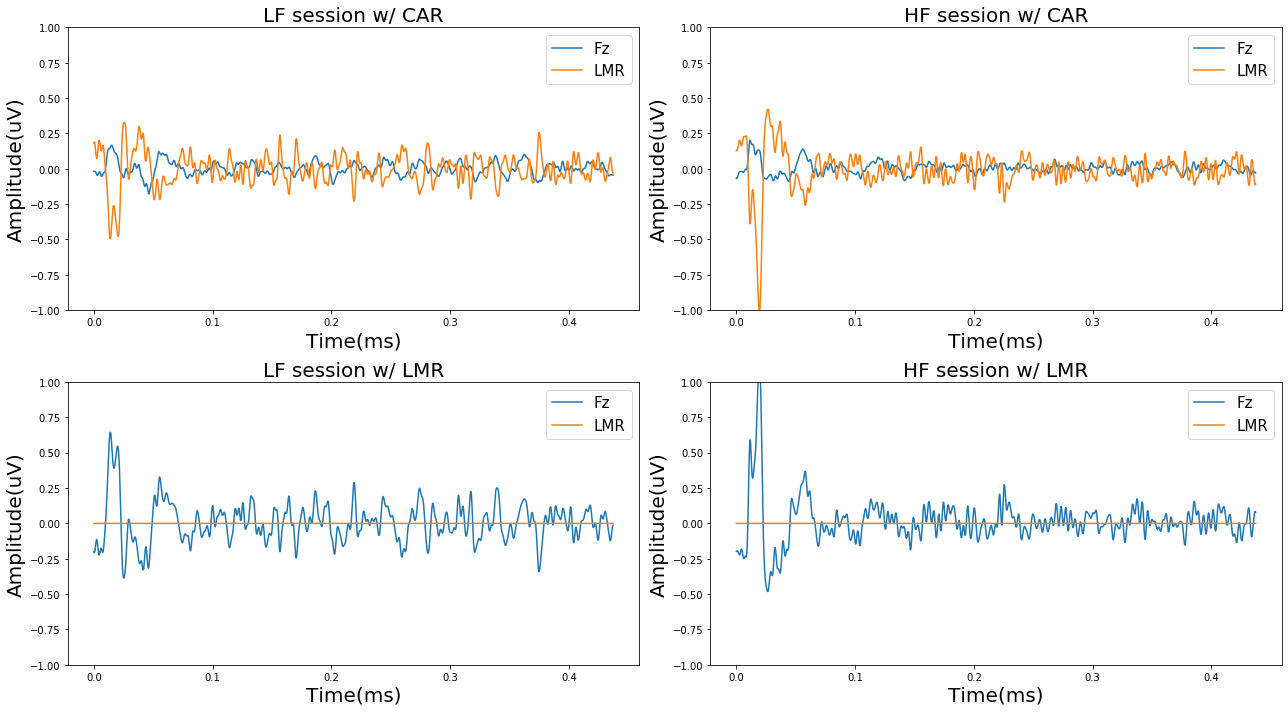

In [119]:
plt.figure(figsize=(18,10))

temporal_mat_ave = temporal_mat.mean(0)*1e6

title_list = ['LF', 'HF']

for iFreq in range(2):

    plt.subplot(2,2, iFreq+1)

    plt.plot(x,temporal_mat_ave[0,iFreq+1,0,:], label='Fz')
    plt.plot(x,temporal_mat_ave[0,iFreq+1,1,:], label='LMR')
    
    plt.legend(fontsize=15)
    
    plt.ylim(-1, 1)
    
    plt.title(title_list[iFreq] + ' session w/ CAR', fontsize=20)
    
    plt.xlabel('Time(ms)', fontsize=20)
    plt.ylabel('Amplitude(uV)', fontsize=20)
    
for iFreq in range(2):
    
    plt.subplot(2,2, 2+iFreq+1)

    plt.plot(x,temporal_mat_ave[1,iFreq+1,0,:], label='Fz')
    plt.plot(x,temporal_mat_ave[1,iFreq+1,1,:], label='LMR')
    
    plt.legend(fontsize=15)
    
    plt.ylim(-1, 1)

    plt.title(title_list[iFreq] + ' session w/ LMR', fontsize=20)
    
    plt.xlabel('Time(ms)', fontsize=20)
    plt.ylabel('Amplitude(uV)', fontsize=20)

plt.tight_layout()